In [1]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Visualize the markov chain probabilities for customer behavior in the supermarket

In [2]:
import pydot # conda install -c anaconda pydot
import networkx as nx # conda install -c anaconda networkx

In [3]:
df_probs = pd.read_csv('probabilities.csv', index_col=0)
df_probs

,checkout,dairy,drinks,entrance,fruit,spices
checkout,1.000,0.000,0.000,0.000,0.000,0.000
dairy,0.095,0.598,0.053,0.104,0.085,0.065
drinks,0.139,0.101,0.455,0.115,0.095,0.095
entrance,0.169,0.253,0.153,0.033,0.265,0.127
fruit,0.136,0.115,0.078,0.149,0.466,0.056
spices,0.125,0.190,0.147,0.138,0.108,0.292


In [ ]:
#Possible locations
locations = ['checkout','dairy','drinks','entrance', 'fruit','spices']

# create a function that maps transition probability dataframe
def get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_prob = get_markov_edges(df_probs)

# create graph object
G = nx.MultiDiGraph()
# nodes correspond to states
G.add_nodes_from(locations)
# print(f'Nodes:\n{G.nodes()}\n')
# edges represent transition probabilities
for k, v in edges_prob.items():
    if v > 0.0:
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination, weight=[v], label=[v])

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for plot
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}

nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'markov.dot')
(graph,) = pydot.graph_from_dot_file('markov.dot')
graph.write_png('markov.png')

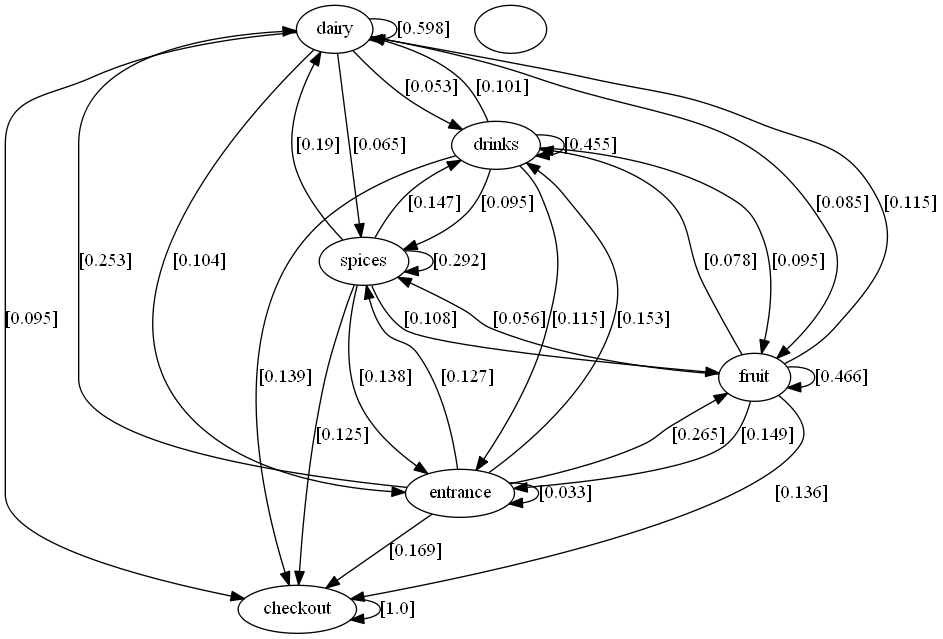

### EDA for the output file of our simulation

In [4]:
output_simulation = pd.read_csv('Test_Supermarket_simulation.csv', sep=',', names=['timestamp', 'customer_no', 'location'])
output_simulation

,timestamp,customer_no,location
0,07:01,9915,drinks
1,07:02,9915,entrance
2,07:02,7165,spices
3,07:03,9915,dairy
4,07:03,7165,spices
...,...,...,...
6970,22:00,8435,fruit
6971,22:00,8054,dairy
6972,22:00,9950,fruit
6973,22:00,6323,checkout


In [5]:
output_simulation["timestamp"] = pd.to_datetime(output_simulation["timestamp"])
output_simulation

,timestamp,customer_no,location
0,2023-03-03 07:01:00,9915,drinks
1,2023-03-03 07:02:00,9915,entrance
2,2023-03-03 07:02:00,7165,spices
3,2023-03-03 07:03:00,9915,dairy
4,2023-03-03 07:03:00,7165,spices
...,...,...,...
6970,2023-03-03 22:00:00,8435,fruit
6971,2023-03-03 22:00:00,8054,dairy
6972,2023-03-03 22:00:00,9950,fruit
6973,2023-03-03 22:00:00,6323,checkout


In [6]:
# Calculate the total number of customers per location
total_customers_per_location = output_simulation.groupby('location')[['customer_no']].count().sort_values('customer_no', ascending=True)
total_customers_per_location

,customer_no
location,
entrance,683
spices,751
checkout,1029
drinks,1035
fruit,1411
dairy,2066


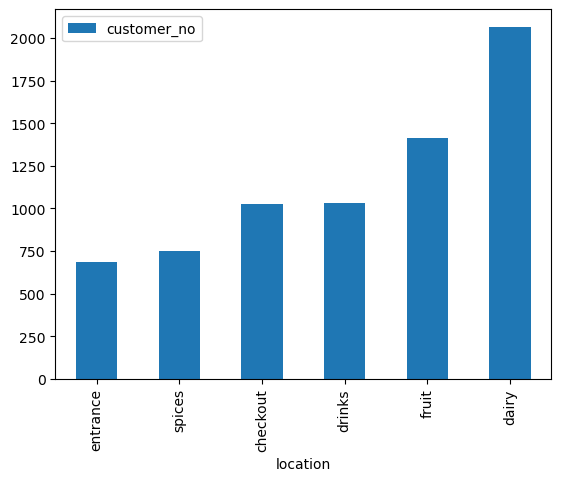

In [7]:
# Plot total customers per location
total_customers_per_location.plot.bar();

In [8]:
# Calculate the total number of customers per location over time
total_customers_per_location_over_time = output_simulation.groupby(['timestamp', 'location']).count()
total_customers_per_location_over_time

customer_no
timestamp           location             
2023-03-03 07:01:00 drinks              1
2023-03-03 07:02:00 entrance            1
                    spices              1
2023-03-03 07:03:00 checkout            1
                    dairy               1
...                                   ...
2023-03-03 21:59:00 spices              1
2023-03-03 22:00:00 checkout            1
                    dairy               1
                    drinks              1
                    fruit               2

[3827 rows x 1 columns]

In [9]:
# Resample the time by hour
total_customers_per_location_over_time = output_simulation.copy()

In [10]:
total_customers_per_location_over_time['hour'] = total_customers_per_location_over_time['timestamp'].dt.hour

In [11]:
total_customers_per_location_over_time

,timestamp,customer_no,location,hour
0,2023-03-03 07:01:00,9915,drinks,7
1,2023-03-03 07:02:00,9915,entrance,7
2,2023-03-03 07:02:00,7165,spices,7
3,2023-03-03 07:03:00,9915,dairy,7
4,2023-03-03 07:03:00,7165,spices,7
...,...,...,...,...
6970,2023-03-03 22:00:00,8435,fruit,22
6971,2023-03-03 22:00:00,8054,dairy,22
6972,2023-03-03 22:00:00,9950,fruit,22
6973,2023-03-03 22:00:00,6323,checkout,22


Plot the peak hours as single graphs

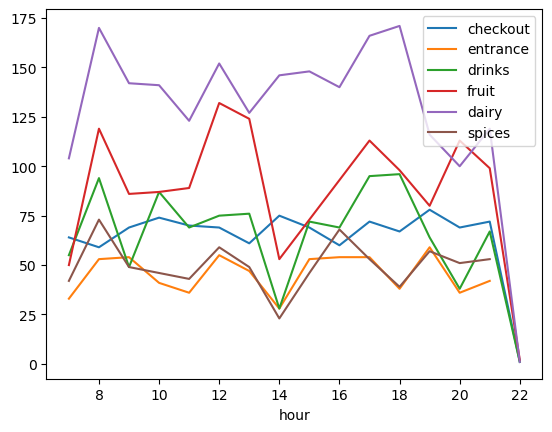

In [12]:
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'checkout'].groupby(['hour']).count().rename({'timestamp':'checkout'},axis=1)['checkout'].plot(legend=True)
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'entrance'].groupby(['hour']).count().rename({'timestamp':'entrance'},axis=1)['entrance'].plot(legend=True)
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'drinks'].groupby(['hour']).count().rename({'timestamp':'drinks'},axis=1)['drinks'].plot(legend=True)
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'fruit'].groupby(['hour']).count().rename({'timestamp':'fruit'},axis=1)['fruit'].plot(legend=True)
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'dairy'].groupby(['hour']).count().rename({'timestamp':'dairy'},axis=1)['dairy'].plot(legend=True)
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'spices'].groupby(['hour']).count().rename({'timestamp':'spices'},axis=1)['spices'].plot(legend=True);

Plot the peak hours as a heatmap

<AxesSubplot: xlabel='location', ylabel='hour'>

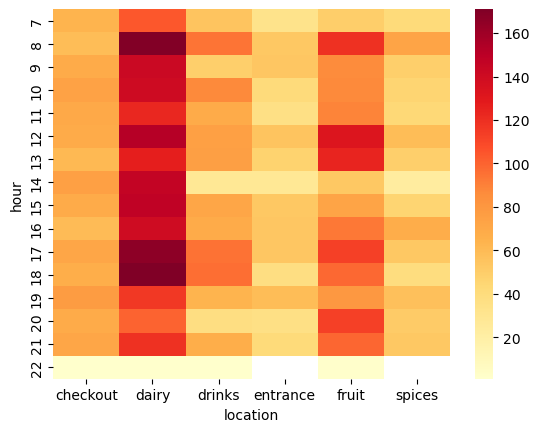

In [24]:
# Pivot the data into a table with hours as rows and locations as columns
pivot_table = total_customers_per_location_over_time.pivot_table(
    index='hour', columns='location', values='timestamp', aggfunc='count')

# Plot the heatmap
sns.heatmap(pivot_table, cmap='YlOrRd')

Plot the peak hours as a heatmap (y-axes: The other way around)

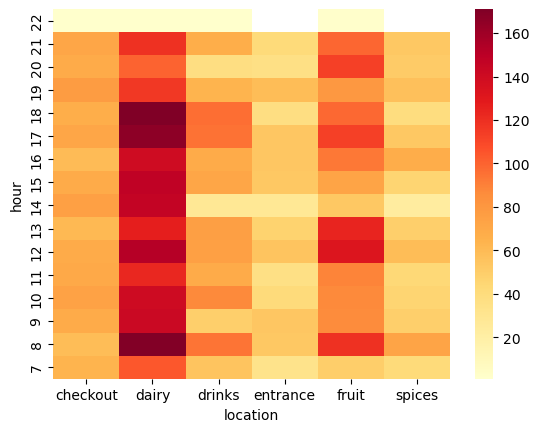

In [29]:
# Pivot the data into a table with hours as rows and locations as columns
pivot_table = total_customers_per_location_over_time.pivot_table(
    index='hour', columns='location', values='timestamp', aggfunc='count')

# Plot the heatmap
ax= sns.heatmap(pivot_table, cmap='YlOrRd')
ax.invert_yaxis()

Consider only checkout frequency

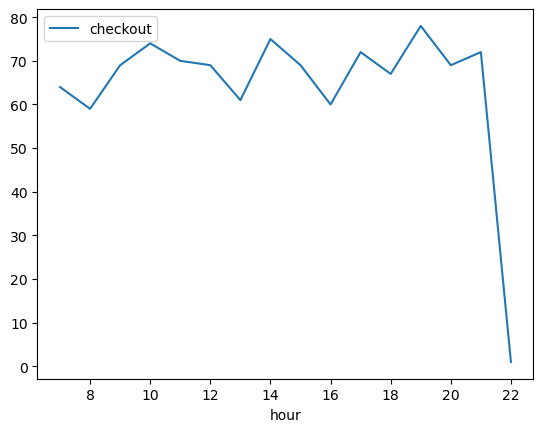

In [13]:
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'checkout'].groupby(['hour']).count().rename({'timestamp':'checkout'},axis=1)['checkout'].plot(legend=True);

Consider only entrance frequency

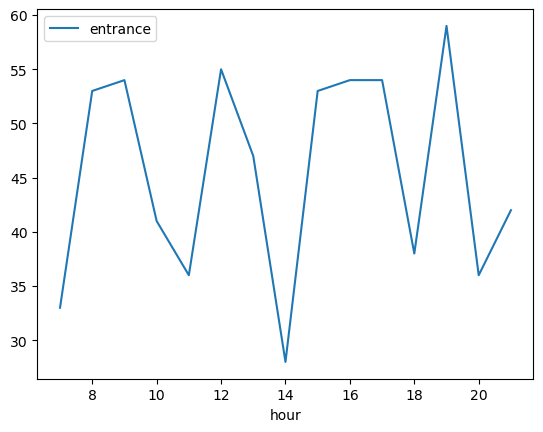

In [14]:
total_customers_per_location_over_time[total_customers_per_location_over_time['location'] == 'entrance'].groupby(['hour']).count().rename({'timestamp':'entrance'},axis=1)['entrance'].plot(legend=True);

Plot the time each customer spent in the whole supermarket

In [15]:
# Calculate the time each customer spent in the market
time_spent = output_simulation.groupby(by=['customer_no'])[['timestamp']].apply(lambda x:x.max() - x.min()).rename({'timestamp':'time_spent'}, axis=1) / pd.Timedelta(minutes=1)
time_spent

,time_spent
customer_no,
12,6.0
19,103.0
21,19.0
29,7.0
37,3.0
...,...
9972,0.0
9973,2.0
9975,0.0


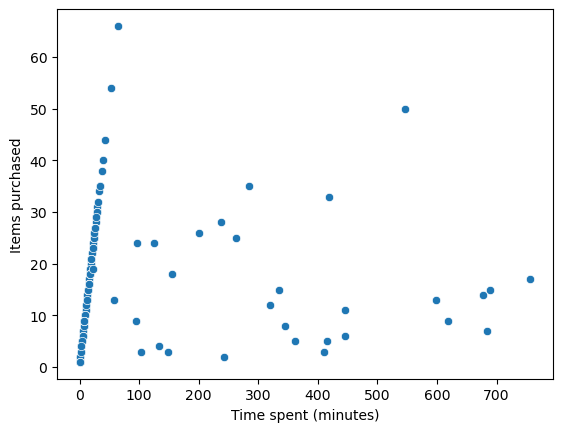

In [16]:
items_purchased = output_simulation.groupby(by=['customer_no'])[['timestamp']].count().rename({'timestamp':'items_purchased'}, axis=1)
merged_data = pd.merge(time_spent, items_purchased, on='customer_no')

sns.scatterplot(x='time_spent', y='items_purchased', data=merged_data)
plt.xlabel('Time spent (minutes)')
plt.ylabel('Items purchased')
plt.show()

Calculate the time each customer spent in specific locations of the supermarket

In [17]:
 # Extend the dataset to get minute-based datapoints of every customer
def to_minute(df):
    """Function to resample customer data to minute steps, forward interpolating the
    location value."""
    grouper = df.set_index('timestamp').groupby('customer_no').resample('min')['location'].ffill()
    resampled_df = grouper.reset_index('timestamp')
    return resampled_df.reset_index()

In [18]:
to_minute(output_simulation)

,customer_no,timestamp,location
0,12,2023-03-03 11:55:00,fruit
1,12,2023-03-03 11:56:00,fruit
2,12,2023-03-03 11:57:00,fruit
3,12,2023-03-03 11:58:00,fruit
4,12,2023-03-03 11:59:00,fruit
...,...,...,...
16773,9977,2023-03-03 14:05:00,checkout
16774,9979,2023-03-03 13:49:00,fruit
16775,9979,2023-03-03 13:50:00,fruit
16776,9979,2023-03-03 13:51:00,drinks
